# Team 1 - Project 1

In [1]:
# Team 1 LendingClub primary notebook
# import dependencies
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import numpy as np  # needed for replace nan code below
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import linregress, spearmanr


In [2]:
# pull in all csvs and merge them into a single dataframe
bigdf = pd.concat([pd.read_csv(f, low_memory=False, usecols=[
    'issue_d', 'loan_amnt', 'term', 'int_rate', 'installment',
    'emp_length', 'home_ownership', 'annual_inc', 'open_acc',
    'grade', 'addr_state', 'delinq_amnt', 'loan_status', 'tot_cur_bal',
    'purpose', 'earliest_cr_line', 'pct_tl_nvr_dlq','mths_since_recent_bc_dlq',
    'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
    'mths_since_recent_bc','title'    
]) for f in glob.glob('data/LoanStats*.csv')], ignore_index=True)

# drop all the empty rows
bigdf.dropna(subset=['term', 'issue_d'], inplace=True)

date_dictionary = {
    "Dec-18": 12,
    "Nov-18": 11,
    "Oct-18": 10,
    "Sep-18": 9,
    "Aug-18": 8,
    "Jul-18": 7,
    "Jun-18": 6,
    "May-18": 5,
    "Apr-18": 4,
    "Mar-18": 3,
    "Feb-18": 2,
    "Jan-18": 1,
}

bigdf["month_num"] = ""  # create new column
bigdf["month_num"] = bigdf["issue_d"].map(date_dictionary)  # map month numbers
bigdf["month_num"] = bigdf["month_num"].round(0).astype(int)  # convert to int from float

# Alice's Code

In [3]:
grade_dictionary = {
    "G": 7,
    "F": 6,
    "E": 5,
    "D": 4,
    "C": 3,
    "B": 2,
    "A": 1,
}

bigdf["numericGrade"] = ""  # create new column
bigdf["numericGrade"] = bigdf["grade"].map(grade_dictionary)  # map grade numbers
bigdf["numericGrade"] = bigdf["numericGrade"].round(0).astype(int)  # convert to int from float

bigdf.head()


,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,...,open_acc,tot_cur_bal,delinq_amnt,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,pct_tl_nvr_dlq,month_num,numericGrade
0,30000.0,36 months,7.34%,930.99,A,3 years,OWN,95000.0,Mar-18,Fully Paid,...,10.0,12704.0,0.0,19.0,NaN,24.0,10.0,90.0,3,1
1,34825.0,60 months,12.61%,785.45,C,2 years,MORTGAGE,125000.0,Mar-18,Current,...,12.0,68270.0,0.0,14.0,45.0,15.0,45.0,96.3,3,3
2,2600.0,36 months,7.96%,81.43,A,3 years,MORTGAGE,62000.0,Mar-18,Current,...,8.0,241067.0,0.0,45.0,NaN,NaN,NaN,100.0,3,1
3,20000.0,60 months,9.92%,424.16,B,3 years,MORTGAGE,110000.0,Mar-18,Current,...,9.0,365026.0,0.0,8.0,NaN,4.0,NaN,90.9,3,2
4,17000.0,60 months,20.39%,454.10,D,10+ years,RENT,52000.0,Mar-18,Current,...,9.0,18039.0,0.0,19.0,77.0,0.0,77.0,85.7,3,4


In [4]:
# clean up and format the interest rate
bigdf['int_rate'] = bigdf['int_rate'].astype(str)
bigdf['int_rate'] = bigdf['int_rate'].str.replace('%','')
bigdf['int_rate'] = pd.to_numeric(bigdf['int_rate'], errors='coerce')
bigdf.dtypes

loan_amnt                         float64
term                               object
int_rate                          float64
installment                       float64
grade                              object
emp_length                         object
home_ownership                     object
annual_inc                        float64
issue_d                            object
loan_status                        object
purpose                            object
title                              object
addr_state                         object
earliest_cr_line                   object
open_acc                          float64
tot_cur_bal                       float64
delinq_amnt                       float64
mths_since_recent_bc              float64
mths_since_recent_bc_dlq          float64
mths_since_recent_inq             float64
mths_since_recent_revol_delinq    float64
pct_tl_nvr_dlq                    float64
month_num                           int32
numericGrade                      

In [5]:
debt_column = bigdf[["purpose", "annual_inc", "tot_cur_bal","home_ownership", "int_rate", "grade"]]
debt_column.head(10)  

,purpose,annual_inc,tot_cur_bal,home_ownership,int_rate,grade
0,house,95000.0,12704.0,OWN,7.34,A
1,credit_card,125000.0,68270.0,MORTGAGE,12.61,C
2,other,62000.0,241067.0,MORTGAGE,7.96,A
3,home_improvement,110000.0,365026.0,MORTGAGE,9.92,B
4,debt_consolidation,52000.0,18039.0,RENT,20.39,D
5,other,50000.0,19344.0,RENT,20.39,D
6,debt_consolidation,19000.0,17709.0,MORTGAGE,10.41,B
7,other,36500.0,13295.0,RENT,17.47,D
8,debt_consolidation,196000.0,534954.0,OWN,9.92,B
9,debt_consolidation,50000.0,243513.0,MORTGAGE,6.07,A


In [6]:
any_home = debt_column.groupby(['home_ownership'])['int_rate'].mean()
any_home

home_ownership
ANY         12.668730
MORTGAGE    12.343863
OWN         12.757874
RENT        13.192447
Name: int_rate, dtype: float64

In [7]:
debt_column.head()


,purpose,annual_inc,tot_cur_bal,home_ownership,int_rate,grade
0,house,95000.0,12704.0,OWN,7.34,A
1,credit_card,125000.0,68270.0,MORTGAGE,12.61,C
2,other,62000.0,241067.0,MORTGAGE,7.96,A
3,home_improvement,110000.0,365026.0,MORTGAGE,9.92,B
4,debt_consolidation,52000.0,18039.0,RENT,20.39,D


In [8]:
print(debt_column["annual_inc"].max())
print(debt_column["annual_inc"].min())

9930475.0
0.0


In [9]:
print(debt_column["int_rate"].max())
print(debt_column["int_rate"].min())

30.99
5.31


In [10]:
bins = [0, 5, 10, 15, 20, 25, 30, 35]

# Create labels for these bins
group_labels = ["0 to 5", "5 to 10", "10 to 15", "15 to 20",
                "20 to 25", "25 to 30", "30 to 35"]

In [11]:
debt_column['bin'] = pd.cut(debt_column['int_rate'], bins=bins,labels=group_labels)
any_home = debt_column.groupby(['home_ownership','bin'])['int_rate'].mean()
any_home_df = any_home.to_frame()
any_home_df['int_rate'] = any_home_df['int_rate'].round(decimals=2)
any_home_df

C:\Users\nnorman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


int_rate
home_ownership bin               
ANY            5 to 10       7.35
               10 to 15     11.72
               15 to 20     17.09
               20 to 25     22.27
               25 to 30     27.01
               30 to 35     30.82
MORTGAGE       5 to 10       7.43
               10 to 15     12.09
               15 to 20     17.06
               20 to 25     22.08
               25 to 30     26.83
               30 to 35     30.61
OWN            5 to 10       7.51
               10 to 15     12.10
               15 to 20     17.11
               20 to 25     22.14
               25 to 30     26.80
               30 to 35     30.62
RENT           5 to 10       7.57
               10 to 15     12.15
               15 to 20     17.09
               20 to 25     22.13
               25 to 30     26.81
               30 to 35     30.62

In [12]:
any_df = any_home_df.loc['ANY']
any_home1 = debt_column.groupby(['home_ownership','bin'])['annual_inc'].mean()
any_home_df1 = any_home1.to_frame()
any_home_df1['annual_inc'] = any_home_df1['annual_inc'].round(decimals=2)
any_df1 = any_home_df1.loc['ANY']
full_df = pd.merge(any_df, any_df1, on='bin')
full_df = full_df.rename(index=str, columns={"annual_inc":"ANY"})

mortgage_df = any_home_df.loc['MORTGAGE']
mortgage_df1 = debt_column[debt_column['home_ownership'] == 'MORTGAGE']
mortgage_df2 = mortgage_df1.groupby(['home_ownership','bin'])['annual_inc'].mean()
mortgage_df3 = mortgage_df2.to_frame()
mortgage_df3['annual_inc'] = mortgage_df3['annual_inc'].round(decimals=2)
mortgage = mortgage_df3.loc['MORTGAGE']
full_df = pd.merge(full_df, mortgage, on='bin')
full_df = full_df.rename(index=str, columns={"annual_inc":"MORTGAGE"})

own_df = any_home_df.loc['OWN']
own_df1 = debt_column[debt_column['home_ownership'] == 'OWN']
own_df2 = own_df1.groupby(['home_ownership','bin'])['annual_inc'].mean()
own_df3 = own_df2.to_frame()
own_df3['annual_inc'] = own_df3['annual_inc'].round(decimals=2)
own = own_df3.loc['OWN']
full_df = pd.merge(full_df, own, on='bin')
full_df = full_df.rename(index=str, columns={"annual_inc":"OWN"})

rent_df = any_home_df.loc['RENT']
rent_df1 = debt_column[debt_column['home_ownership'] == 'RENT']
rent_df2 = rent_df1.groupby(['home_ownership','bin'])['annual_inc'].mean()
rent_df3 = rent_df2.to_frame()
rent_df3['annual_inc'] = rent_df3['annual_inc'].round(decimals=2)
rent = rent_df3.loc['RENT']
full_df = pd.merge(full_df, rent, on='bin')
full_df = full_df.rename(index=str, columns={"annual_inc":"RENT"})
full_df

,int_rate,ANY,MORTGAGE,OWN,RENT
bin,,,,,
5 to 10,7.35,64768.66,98198.70,80250.87,73920.91
10 to 15,11.72,49904.91,89702.90,72741.87,68234.79
15 to 20,17.09,56404.51,84551.92,67342.34,65230.06
20 to 25,22.27,49237.15,82730.16,65909.80,63330.24
25 to 30,27.01,56306.67,83173.69,67733.94,64918.14
30 to 35,30.82,28914.00,76881.99,68669.45,61922.98


In [13]:
any1 = full_df['ANY'].tolist()
mortgage1 = full_df['MORTGAGE'].tolist()
own1 = full_df['OWN'].tolist()
rent1 = full_df['RENT'].tolist()
#index_v = ["5 to 10", "10 to 15", "15 to 20","20 to 25", "25 to 30", "30 to 35"]
index_v = [10, 15, 20, 25, 30, 35]
new_df = pd.DataFrame({'ANY':any1, 'MORTGAGE':mortgage1,'OWN':own1, 'RENT':rent1}, index=index_v)
new_df.head(10)

,ANY,MORTGAGE,OWN,RENT
10,64768.66,98198.70,80250.87,73920.91
15,49904.91,89702.90,72741.87,68234.79
20,56404.51,84551.92,67342.34,65230.06
25,49237.15,82730.16,65909.80,63330.24
30,56306.67,83173.69,67733.94,64918.14
35,28914.00,76881.99,68669.45,61922.98


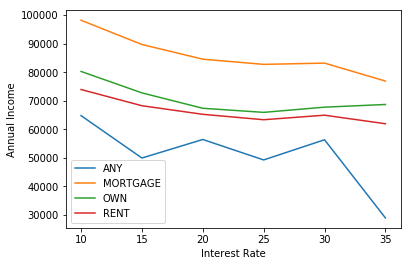

In [14]:
fig, ax = plt.subplots()
new_df.plot(kind='line', ax=ax)
ax.set_xlabel("Interest Rate")
ax.set_ylabel("Annual Income")
plt.show()

# Mike's Code

In [15]:
mike_df=bigdf[bigdf.emp_length!= '10+ years']
mike_df=mike_df[mike_df.emp_length!= 0]
mike_df['emp_length'] = mike_df['emp_length'].str.replace("years","")
mike_df['emp_length'] = mike_df['emp_length'].str.replace("year","")
mike_df['emp_length'] = mike_df['emp_length'].str.replace("<","")

mike_df['rd_loan_amnt'] = mike_df['loan_amnt'].div(1000000).round(2)

mike_df['emp_length'] = pd.to_numeric(mike_df['emp_length'], errors='coerce')

In [16]:
mike_df['mths_since_recent_bc']=mike_df['mths_since_recent_bc'].replace(np.nan, 0)
mike_df['mths_since_recent_bc_dlq']=mike_df['mths_since_recent_bc_dlq'].replace(np.nan, 0)
mike_df['mths_since_recent_inq']=mike_df['mths_since_recent_inq'].replace(np.nan, 0)
mike_df['emp_length']=mike_df['emp_length'].replace(np.nan, 0)
mike_df['mths_since_recent_revol_delinq']=mike_df['mths_since_recent_revol_delinq'].replace(np.nan, 0)

mike_df.dropna(subset=['term', 'issue_d'], inplace=True)

mike_df["int_rate"] = mike_df["int_rate"].round(2)

In [17]:
impute_grps = mike_df.pivot_table(values=["int_rate"], index=["month_num"], aggfunc=np.mean).reset_index()
impute_grps.columns=['Month','Interest Rate']
impute_grps

,Month,Interest Rate
0,1,12.467186
1,2,12.569539
2,3,12.524404
3,4,12.629658
4,5,12.681132
5,6,12.626875
6,7,13.181279
7,8,13.084319
8,9,12.785070
9,10,12.754339


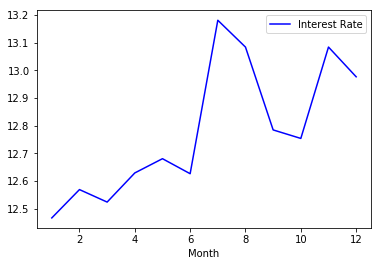

In [18]:
impute_grps.plot(kind='line',x='Month',y='Interest Rate',color='blue')

In [19]:
ct=pd.crosstab(mike_df.emp_length, mike_df.title, values=mike_df.rd_loan_amnt, aggfunc='sum').round(0)
#ct.plot.bar(stacked=True)
#plt.legend(title='mark')
pd.options.display.float_format = '{:,}'.format

ct

title,Business,Car financing,Credit card refinancing,Debt consolidation,Green loan,Home buying,Home improvement,Major purchase,Medical expenses,Moving and relocation,Other,Vacation
emp_length,,,,,,,,,,,,
0.0,2.0,4.0,120.0,316.0,0.0,7.0,40.0,9.0,7.0,2.0,30.0,2.0
1.0,20.0,8.0,336.0,665.0,1.0,13.0,59.0,28.0,9.0,6.0,62.0,2.0
2.0,8.0,5.0,192.0,381.0,0.0,8.0,35.0,19.0,6.0,3.0,36.0,1.0
3.0,8.0,4.0,170.0,360.0,0.0,7.0,35.0,15.0,5.0,3.0,34.0,2.0
4.0,6.0,3.0,129.0,274.0,0.0,6.0,29.0,12.0,4.0,2.0,26.0,1.0
5.0,6.0,4.0,126.0,279.0,0.0,6.0,32.0,12.0,4.0,2.0,26.0,1.0
6.0,4.0,2.0,91.0,202.0,0.0,4.0,24.0,8.0,4.0,1.0,16.0,1.0
7.0,4.0,2.0,76.0,165.0,0.0,4.0,19.0,7.0,3.0,1.0,14.0,1.0
8.0,3.0,2.0,68.0,151.0,0.0,3.0,18.0,6.0,2.0,1.0,13.0,1.0


C:\Users\nnorman\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


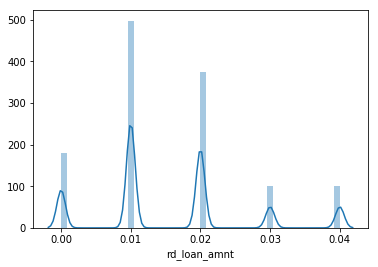

In [20]:
sns.distplot(mike_df.rd_loan_amnt.dropna())

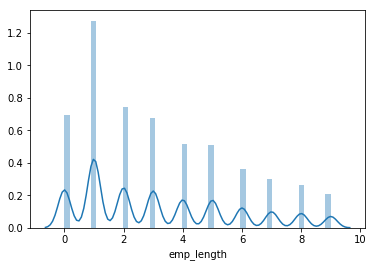

In [21]:
sns.distplot(mike_df.emp_length.dropna())

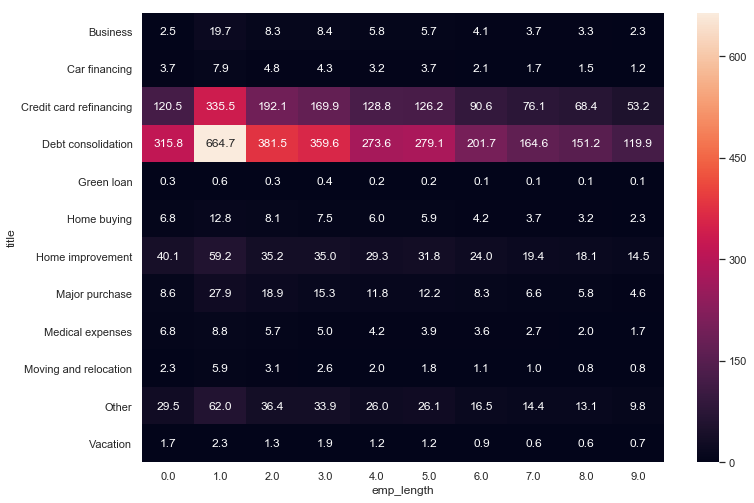

In [22]:
ct1 = mike_df.pivot_table(index='title',columns='emp_length', values='rd_loan_amnt', aggfunc=np.sum)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(ct1, annot=True, fmt=".1f")

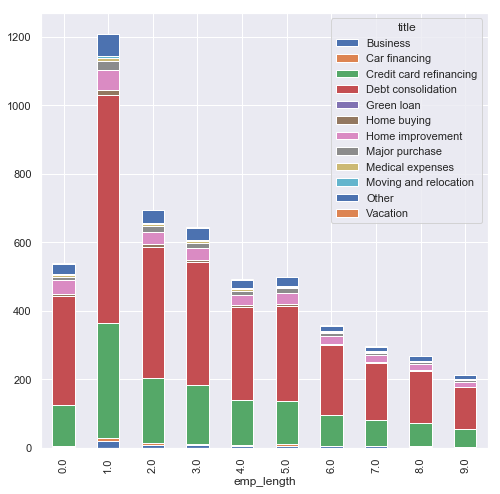

In [23]:
ct.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

# Juhlian's Code

In [24]:
# Start Juhlian Code. Create cross table of DLQ data
Percent_table=pd.crosstab(mike_df.grade, mike_df.loan_status, values=mike_df.rd_loan_amnt, aggfunc='count').round(0)
Percent_table["Default"] = Percent_table["Default"].fillna(0)

In [25]:
# Create grand total and percentage columns
Percent_table['Grand Total'] = Percent_table["Charged Off"] + Percent_table["Current"]+ Percent_table["Default"]+Percent_table["Fully Paid"]+Percent_table["In Grace Period"]+Percent_table["Late (16-30 days)"]+Percent_table["Late (31-120 days)"]
Percent_table["Charged_Off"] = Percent_table["Charged Off"]/Percent_table["Grand Total"]*100
Percent_table["Current "] = Percent_table["Current"]/Percent_table["Grand Total"]*100
Percent_table["Default "] = Percent_table["Default"]/Percent_table["Grand Total"]*100
Percent_table["Fully_Paid"] = Percent_table["Fully Paid"]/Percent_table["Grand Total"]*100
Percent_table["In_Grace_Period"] = Percent_table["In Grace Period"]/Percent_table["Grand Total"]*100
Percent_table["Late_(16-30 days)"] = Percent_table["Late (16-30 days)"]/Percent_table["Grand Total"]*100
Percent_table["Late_(31-120 days)"] = Percent_table["Late (31-120 days)"]/Percent_table["Grand Total"]*100
Percent_table

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Grand Total,Charged_Off,Current,Default,Fully_Paid,In_Grace_Period,Late_(16-30 days),Late_(31-120 days)
grade,,,,,,,,,,,,,,,
A,359.0,"82,873.0",1.0,"6,514.0",214.0,78.0,305.0,"90,344.0",0.3973700522447534,91.73049676790932,0.0011068803683697867,7.210218719560791,0.23687239883113434,0.08633666873284335,0.33759851235278493
B,981.0,"84,873.0",2.0,"7,514.0",450.0,219.0,957.0,"94,996.0",1.0326750600025265,89.3437618426039,0.0021053518042864964,7.909806728704366,0.47370415596446164,0.23053602256937136,1.0074108383510885
C,"1,524.0","75,672.0",1.0,"6,680.0",688.0,298.0,"1,547.0","86,410.0",1.763684758708483,87.57319754658026,0.001157273463719477,7.730586737646106,0.7962041430390001,0.3448674921884041,1.7903020483740306
D,"1,415.0","39,812.0",3.0,"4,066.0",476.0,257.0,"1,276.0","47,305.0",2.991227143008139,84.16023676144171,0.006341824331466019,8.595285910580278,1.006236127259275,0.5432829510622555,2.69738928231688
E,520.0,"10,749.0",1.0,"1,258.0",126.0,65.0,474.0,"13,193.0",3.941484120366861,81.47502463427575,0.0075797771545516555,9.535359660425984,0.9550519214735086,0.4926855150458576,3.592814371257485
F,119.0,"1,615.0",0.0,240.0,28.0,18.0,126.0,"2,146.0",5.54520037278658,75.25629077353216,0.0,11.183597390493942,1.30475302889096,0.8387698042870456,5.871388630009319
G,36.0,340.0,0.0,48.0,8.0,8.0,26.0,466.0,7.725321888412018,72.96137339055794,0.0,10.300429184549357,1.7167381974248928,1.7167381974248928,5.579399141630901


In [26]:
# Columns for dataframe using only the percentage columns created
col = ["Fully_Paid","Current ","In_Grace_Period","Late_(16-30 days)","Late_(31-120 days)","Default ","Charged_Off"]
Percent_Final = Percent_table[col]

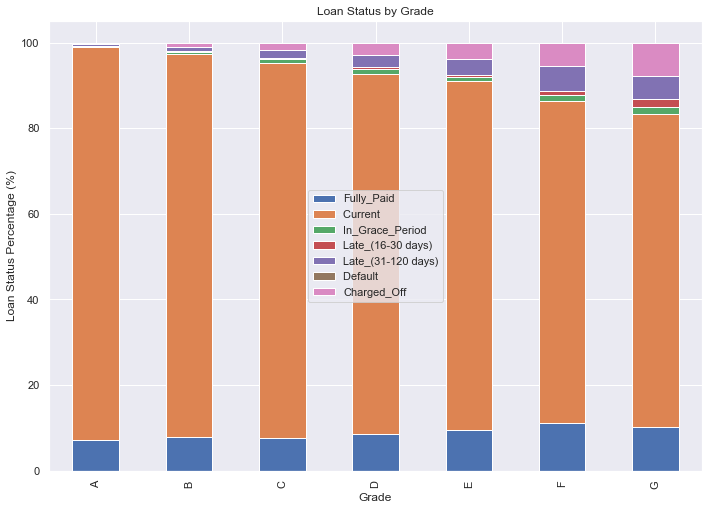

In [27]:
# plot Percent final table
Percent_Final.plot(kind='bar',stacked=True)
plt.legend(loc="center")
plt.title("Loan Status by Grade")
plt.ylabel("Loan Status Percentage (%)")
plt.xlabel("Grade")
plt.savefig("images/loan Status by Grade 100% Stacked Bar Chart.png")

# NOTE: DURING MERGE OF TEAMS CODE, JUHLIAN USED THE MIKES CLEANUP CODE, ALL REFERENCES TO MIKE'S DF ARE SOLELY FOR THE PURPOSE OF CLEAN WORKFLOW. JUHLIANS CODE ORIGINALLY REFERENCED "Bigdf".

In [28]:
#NOTE: DURING MERGE OF TEAMS CODE, JUHLIAN USED THE MIKES CLEANUP CODE, ALL REFERENCES 
# TO MIKE'S DF ARE SOLELY FOR THE PURPOSE OF CLEAN WORKFLOW. JUHLIANS CODE ORIGINALLY REFERENCED "Bigdf".

# Create Quarter collumn and assign values
mike_df["Quarter"] = ""
mike_df.loc[mike_df['month_num'] == 12, ("Quarter")] = ("Q4")
mike_df.loc[mike_df['month_num'] == 11, ("Quarter")] = ("Q4")
mike_df.loc[mike_df['month_num'] == 10, ("Quarter")] = ("Q4")
mike_df.loc[mike_df['month_num'] == 9, ("Quarter")] = ("Q3")
mike_df.loc[mike_df['month_num'] == 8, ("Quarter")] = ("Q3")
mike_df.loc[mike_df['month_num'] == 7, ("Quarter")] = ("Q3")
mike_df.loc[mike_df['month_num'] == 6, ("Quarter")] = ("Q2")
mike_df.loc[mike_df['month_num'] == 5, ("Quarter")] = ("Q2")
mike_df.loc[mike_df['month_num'] == 4, ("Quarter")] = ("Q2")
mike_df.loc[mike_df['month_num'] == 3, ("Quarter")] = ("Q1")
mike_df.loc[mike_df['month_num'] == 2, ("Quarter")] = ("Q1")
mike_df.loc[mike_df['month_num'] == 1, ("Quarter")] = ("Q1")
mike_df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,...,delinq_amnt,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,pct_tl_nvr_dlq,month_num,numericGrade,rd_loan_amnt,Quarter
0,"30,000.0",36 months,7.34,930.99,A,3.0,OWN,"95,000.0",Mar-18,Fully Paid,...,0.0,19.0,0.0,24.0,10.0,90.0,3,1,0.03,Q1
1,"34,825.0",60 months,12.61,785.45,C,2.0,MORTGAGE,"125,000.0",Mar-18,Current,...,0.0,14.0,45.0,15.0,45.0,96.3,3,3,0.03,Q1
2,"2,600.0",36 months,7.96,81.43,A,3.0,MORTGAGE,"62,000.0",Mar-18,Current,...,0.0,45.0,0.0,0.0,0.0,100.0,3,1,0.0,Q1
3,"20,000.0",60 months,9.92,424.16,B,3.0,MORTGAGE,"110,000.0",Mar-18,Current,...,0.0,8.0,0.0,4.0,0.0,90.9,3,2,0.02,Q1
5,"5,000.0",36 months,20.39,186.82,D,8.0,RENT,"50,000.0",Mar-18,Current,...,0.0,11.0,0.0,2.0,0.0,77.8,3,4,0.0,Q1


In [29]:

# count Q1 records and dlq records to create 1st Quarter DLQ Rate
cleanQ1 = mike_df[mike_df["Quarter"]=="Q1"]
Q1_Total = cleanQ1["Quarter"].count()
Q1_Late = cleanQ1[(cleanQ1["loan_status"]== "Late (31-120 days)") | (cleanQ1["loan_status"]== "Late (16-30 days)")]
Q1_DLQ = Q1_Late["loan_status"].count()
Q1_DLQ_Rate = Q1_DLQ/Q1_Total*100

# count Q2 records and dlq records to create 2nd Quarter DLQ Rate
cleanQ2 = mike_df[mike_df["Quarter"]=="Q2"]
Q2_Total = cleanQ2["Quarter"].count()
Q2_Late = cleanQ2[(cleanQ2["loan_status"]== "Late (31-120 days)") | (cleanQ2["loan_status"]== "Late (16-30 days)")]
Q2_DLQ = Q2_Late["loan_status"].count()
Q2_DLQ_Rate = Q2_DLQ/Q2_Total*100

# count Q3 records and dlq records to create 3rd Quarter DLQ Rate
cleanQ3 = mike_df[mike_df["Quarter"]=="Q3"]
Q3_Total = cleanQ3["Quarter"].count()
Q3_Late = cleanQ3[(cleanQ3["loan_status"]== "Late (31-120 days)") | (cleanQ3["loan_status"]== "Late (16-30 days)")]
Q3_DLQ = Q3_Late["loan_status"].count()
Q3_DLQ_Rate = Q3_DLQ/Q3_Total*100

# count Q4 records and dlq records to create 4tj Quarter DLQ Rate
cleanQ4 = mike_df[mike_df["Quarter"]=="Q4"]
Q4_Total = cleanQ4["Quarter"].count()
Q4_Late = cleanQ4[(cleanQ4["loan_status"]== "Late (31-120 days)") | (cleanQ4["loan_status"]== "Late (16-30 days)")]
Q4_DLQ = Q4_Late["loan_status"].count()
Q4_DLQ_Rate = Q4_DLQ/Q4_Total*100

print(Q1_DLQ_Rate)
print(Q2_DLQ_Rate)
print(Q3_DLQ_Rate)
print(Q4_DLQ_Rate)

d = {'QUARTER': ["Q1", "Q2","Q3","Q4"], 'DLQRate': [Q1_DLQ_Rate,Q2_DLQ_Rate,Q3_DLQ_Rate,Q4_DLQ_Rate]}
Clean_df = pd.DataFrame(data=d)



Clean_df

2.4487929266332213
2.35173706544614
1.4891073480425725
0.6239814256691895


,QUARTER,DLQRate
0,Q1,2.4487929266332213
1,Q2,2.35173706544614
2,Q3,1.4891073480425725
3,Q4,0.6239814256691895


In [30]:
# Import federal reserve data and create dataframe for 2018 data
fed_data = pd.read_csv("data/DRCCLACBS - federal reserve delinquency rates.csv")
fed_data["DATE"] = pd.to_datetime(fed_data["DATE"])
fed_data2018 = fed_data[fed_data["DATE"]>="1/1/2018"]
fed_data2018 = fed_data2018.rename(columns={'DRCCLACBS':'DLQ Rate'})
fed_data2018 = fed_data2018.reset_index()
fed_data2018

,index,DATE,QUARTER,DLQ Rate
0,108,2018-01-01,Q1,2.54
1,109,2018-04-01,Q2,2.48
2,110,2018-07-01,Q3,2.49
3,111,2018-10-01,Q4,2.54


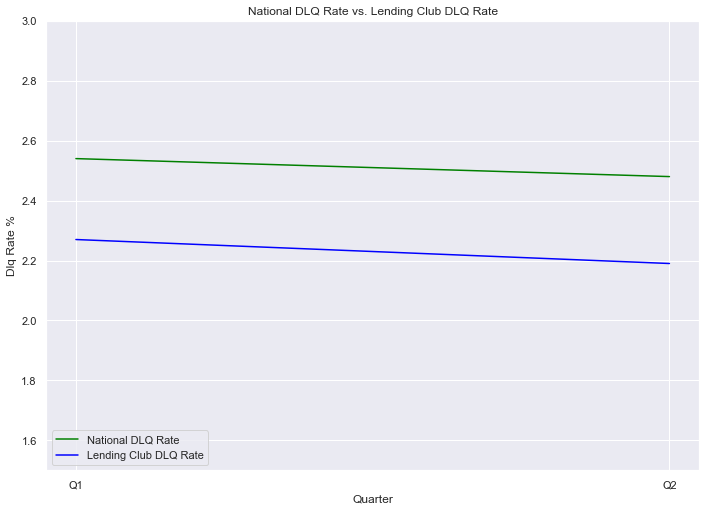

<Figure size 842.4x595.44 with 0 Axes>

In [31]:
# Merge Fed Data with clean data
merged_DF = pd.merge(fed_data2018,Clean_df, left_on ="QUARTER",right_on="QUARTER")

# Create a list of the months that we will use as our x axis
Quarters = ["Q1","Q2",]
Fed_Data = [2.54,2.48]
Data = [2.27,2.19]

# Plot our line that will be used to track a wrestler's wins over the years
plt.plot(Quarters, Fed_Data, color="green", label="National DLQ Rate")

# Plot our line that will be used to track a wrestler's losses over the years
plt.plot(Quarters, Data, color="blue", label="Lending Club DLQ Rate")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="lower left")

plt.title("National DLQ Rate vs. Lending Club DLQ Rate")
plt.xlabel("Quarter")
plt.ylabel("Dlq Rate %")
plt.ylim(1.5,3)


plt.xticks(Quarters)
# Print our chart to the screen
plt.show()
plt.savefig("images/National DLQ Rate Lending Club DLQ Rate.png")


# Tifare's code

In [32]:
mydf= pd.read_csv('data/VIX.csv')
mydf = mydf.round(2)
mydf

,issue_d,Open,High,Low,Close,Adj Close
0,1-Jan,10.95,15.42,8.92,13.54,13.54
1,1-Feb,13.05,50.3,12.5,19.85,19.85
2,1-Mar,19.96,26.22,13.31,19.97,19.97
3,1-Apr,21.07,25.72,14.57,15.93,15.93
4,1-May,16.0,18.78,10.91,15.43,15.43
5,1-Jun,14.92,19.61,11.22,16.09,16.09
6,1-Jul,17.7,18.08,11.44,12.83,12.83
7,1-Aug,13.09,16.86,10.17,12.86,12.86
8,1-Sep,13.13,15.63,11.1,12.12,12.12
9,1-Oct,11.99,28.84,11.34,21.23,21.23


In [33]:
#Assigning month numbers for merging for VIX data
mydf["month_num"] = ""
mydf.loc[mydf['issue_d'].str[2:] == "Dec", ('month_num')] = (12)
mydf.loc[mydf['issue_d'].str[2:] == "Nov", ('month_num')] = (11)
mydf.loc[mydf['issue_d'].str[2:] == "Oct", ('month_num')] = (10)
mydf.loc[mydf['issue_d'].str[2:] == "Sep", ('month_num')] = (9)
mydf.loc[mydf['issue_d'].str[2:] == "Aug", ('month_num')] = (8)
mydf.loc[mydf['issue_d'].str[2:] == "Jul", ('month_num')] = (7)
mydf.loc[mydf['issue_d'].str[2:] == "Jun", ('month_num')] = (6)
mydf.loc[mydf['issue_d'].str[2:] == "May", ('month_num')] = (5)
mydf.loc[mydf['issue_d'].str[2:] == "Apr", ('month_num')] = (4)
mydf.loc[mydf['issue_d'].str[2:] == "Mar", ('month_num')] = (3)
mydf.loc[mydf['issue_d'].str[2:] == "Feb", ('month_num')] = (2)
mydf.loc[mydf['issue_d'].str[2:] == "Jan", ('month_num')] = (1)
mydf.loc[mydf['issue_d'].str[2:] == "", ('month_num')] = (0)

mydf.head()

,issue_d,Open,High,Low,Close,Adj Close,month_num
0,1-Jan,10.95,15.42,8.92,13.54,13.54,1
1,1-Feb,13.05,50.3,12.5,19.85,19.85,2
2,1-Mar,19.96,26.22,13.31,19.97,19.97,3
3,1-Apr,21.07,25.72,14.57,15.93,15.93,4
4,1-May,16.0,18.78,10.91,15.43,15.43,5


In [34]:
nasdaq_df= pd.read_csv('data/IXIC.csv')
nasdaq_df = nasdaq_df.round(2)
nasdaq_df.head()

,Date,Adj Close
0,1-Jan,"7,411.48"
1,1-Feb,"7,273.01"
2,1-Mar,"7,063.45"
3,1-Apr,"7,066.27"
4,1-May,"7,442.12"


In [35]:
#Assigning month numbers for merging for Nasdaq data
nasdaq_df["month_num"] = ""
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Dec", ('month_num')] = (12)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Nov", ('month_num')] = (11)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Oct", ('month_num')] = (10)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Sep", ('month_num')] = (9)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Aug", ('month_num')] = (8)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Jul", ('month_num')] = (7)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Jun", ('month_num')] = (6)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "May", ('month_num')] = (5)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Apr", ('month_num')] = (4)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Mar", ('month_num')] = (3)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Feb", ('month_num')] = (2)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "Jan", ('month_num')] = (1)
nasdaq_df.loc[nasdaq_df['Date'].str[2:] == "", ('month_num')] = (0)

In [36]:
#Assigns month number to allow merging
nasdaq_df.head()

,Date,Adj Close,month_num
0,1-Jan,"7,411.48",1
1,1-Feb,"7,273.01",2
2,1-Mar,"7,063.45",3
3,1-Apr,"7,066.27",4
4,1-May,"7,442.12",5


In [37]:
#Ensuring that we are only using 2018 data for VIX
cleanmydf= mydf.dropna()
cleanmydf

,issue_d,Open,High,Low,Close,Adj Close,month_num
0,1-Jan,10.95,15.42,8.92,13.54,13.54,1
1,1-Feb,13.05,50.3,12.5,19.85,19.85,2
2,1-Mar,19.96,26.22,13.31,19.97,19.97,3
3,1-Apr,21.07,25.72,14.57,15.93,15.93,4
4,1-May,16.0,18.78,10.91,15.43,15.43,5
5,1-Jun,14.92,19.61,11.22,16.09,16.09,6
6,1-Jul,17.7,18.08,11.44,12.83,12.83,7
7,1-Aug,13.09,16.86,10.17,12.86,12.86,8
8,1-Sep,13.13,15.63,11.1,12.12,12.12,9
9,1-Oct,11.99,28.84,11.34,21.23,21.23,10


In [38]:
#Reading in DOW Jones Data
otherdf= pd.read_csv('data/DJI.csv')
otherdf = otherdf.round(2)
otherdf.dropna()

,issue_d,Open,High,Low,Close,Adj Close,Volume
0,1-Jan,"24,809.35","26,616.71","24,741.7","26,149.39","26,149.39",9116920000
1,1-Feb,"26,083.04","26,306.7","23,360.29","25,029.2","25,029.2",9450250000
2,1-Mar,"25,024.04","25,449.15","23,509.06","24,103.11","24,103.11",8873040000
3,1-Apr,"24,076.6","24,858.97","23,344.52","24,163.15","24,163.15",8064550000
4,1-May,"24,117.29","25,086.49","23,531.31","24,415.84","24,415.84",7278020000
5,1-Jun,"24,542.09","25,402.83","23,997.21","24,271.41","24,271.41",7411110000
6,1-Jul,"24,161.53","25,587.24","24,077.56","25,415.19","25,415.19",5408500000
7,1-Aug,"25,461.63","26,167.94","24,965.77","25,964.82","25,964.82",5635410000
8,1-Sep,"25,916.07","26,769.16","25,754.32","26,458.31","26,458.31",5262500000
9,1-Oct,"26,598.36","26,951.81","24,122.23","25,115.76","25,115.76",8373350000


In [39]:
#Assigning month numbers for merging for DOW data
otherdf["month_num"] = ""
otherdf.loc[otherdf['issue_d'].str[2:] == "Dec", ('month_num')] = (12)
otherdf.loc[otherdf['issue_d'].str[2:] == "Nov", ('month_num')] = (11)
otherdf.loc[otherdf['issue_d'].str[2:] == "Oct", ('month_num')] = (10)
otherdf.loc[otherdf['issue_d'].str[2:] == "Sep", ('month_num')] = (9)
otherdf.loc[otherdf['issue_d'].str[2:] == "Aug", ('month_num')] = (8)
otherdf.loc[otherdf['issue_d'].str[2:] == "Jul", ('month_num')] = (7)
otherdf.loc[otherdf['issue_d'].str[2:] == "Jun", ('month_num')] = (6)
otherdf.loc[otherdf['issue_d'].str[2:] == "May", ('month_num')] = (5)
otherdf.loc[otherdf['issue_d'].str[2:] == "Apr", ('month_num')] = (4)
otherdf.loc[otherdf['issue_d'].str[2:] == "Mar", ('month_num')] = (3)
otherdf.loc[otherdf['issue_d'].str[2:] == "Feb", ('month_num')] = (2)
otherdf.loc[otherdf['issue_d'].str[2:] == "Jan", ('month_num')] = (1)
otherdf.loc[otherdf['issue_d'].str[2:] == "", ('month_num')] = (0)

In [40]:
#First 5 rows of Dow data
otherdf.head()

,issue_d,Open,High,Low,Close,Adj Close,Volume,month_num
0,1-Jan,"24,809.35","26,616.71","24,741.7","26,149.39","26,149.39",9116920000,1
1,1-Feb,"26,083.04","26,306.7","23,360.29","25,029.2","25,029.2",9450250000,2
2,1-Mar,"25,024.04","25,449.15","23,509.06","24,103.11","24,103.11",8873040000,3
3,1-Apr,"24,076.6","24,858.97","23,344.52","24,163.15","24,163.15",8064550000,4
4,1-May,"24,117.29","25,086.49","23,531.31","24,415.84","24,415.84",7278020000,5


In [41]:
cleanmydf['month_num'] = pd.to_numeric(cleanmydf['month_num'], errors='coerce')
cleanmydf['month_num'] = cleanmydf['month_num'].round(0).astype(int)

C:\Users\nnorman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\nnorman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
cleanmydf.dtypes

issue_d       object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
month_num      int32
dtype: object

In [43]:
#Merged Loan data with Vix data
merged_df = bigdf.merge(cleanmydf,how = "inner",on = "month_num")
new_merged_df= merged_df.drop([
    'Close','issue_d_x','issue_d_y','installment',
    'grade','loan_status','purpose','title',
    'mths_since_recent_bc_dlq', 'addr_state',
    'earliest_cr_line','tot_cur_bal','mths_since_recent_bc',
    'mths_since_recent_inq','mths_since_recent_revol_delinq',
    'pct_tl_nvr_dlq','numericGrade','delinq_amnt'
],axis = 1)
pd.DataFrame(new_merged_df).head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,open_acc,month_num,Open,High,Low,Adj Close
0,"30,000.0",36 months,7.34,3 years,OWN,"95,000.0",10.0,3,19.96,26.22,13.31,19.97
1,"34,825.0",60 months,12.61,2 years,MORTGAGE,"125,000.0",12.0,3,19.96,26.22,13.31,19.97
2,"2,600.0",36 months,7.96,3 years,MORTGAGE,"62,000.0",8.0,3,19.96,26.22,13.31,19.97
3,"20,000.0",60 months,9.92,3 years,MORTGAGE,"110,000.0",9.0,3,19.96,26.22,13.31,19.97
4,"17,000.0",60 months,20.39,10+ years,RENT,"52,000.0",9.0,3,19.96,26.22,13.31,19.97


In [44]:
#Made int_rate column from string to float 
#new_merged_df['int_rate'] = new_merged_df['int_rate'].str[:-1].astype(float)
#new_merged_df.head()
new_merged_df.dtypes

loan_amnt         float64
term               object
int_rate          float64
emp_length         object
home_ownership     object
annual_inc        float64
open_acc          float64
month_num           int32
Open              float64
High              float64
Low               float64
Adj Close         float64
dtype: object

In [45]:
Jan = new_merged_df[new_merged_df["month_num"] == 1]
Feb = new_merged_df[new_merged_df["month_num"] == 2]
Mar = new_merged_df[new_merged_df["month_num"] == 3]
Apr = new_merged_df[new_merged_df["month_num"] == 4]
May = new_merged_df[new_merged_df["month_num"] == 5]
Jun = new_merged_df[new_merged_df["month_num"] == 6]
Jul = new_merged_df[new_merged_df["month_num"] == 7]
Aug = new_merged_df[new_merged_df["month_num"] == 8]
Sept = new_merged_df[new_merged_df["month_num"] == 9]
Oct = new_merged_df[new_merged_df["month_num"] == 10]
Nov = new_merged_df[new_merged_df["month_num"] == 11]
Dec = new_merged_df[new_merged_df["month_num"] == 12]
Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May','June','July','Aug','Sept','Oct','Nov',"Dec"]
Months

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'June',
 'July',
 'Aug',
 'Sept',
 'Oct',
 'Nov',
 'Dec']

In [46]:
Jan.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,open_acc,month_num,Open,High,Low,Adj Close
71517,"6,500.0",36 months,7.97,10+ years,MORTGAGE,"24,000.0",5.0,1,10.95,15.42,8.92,13.54
71518,"13,200.0",36 months,5.32,4 years,OWN,"85,000.0",7.0,1,10.95,15.42,8.92,13.54
71519,"30,000.0",36 months,16.02,10+ years,MORTGAGE,"75,000.0",17.0,1,10.95,15.42,8.92,13.54
71520,"4,500.0",36 months,6.08,10+ years,RENT,"36,000.0",23.0,1,10.95,15.42,8.92,13.54
71521,"8,000.0",36 months,21.45,6 years,MORTGAGE,"34,000.0",11.0,1,10.95,15.42,8.92,13.54


In [47]:
#Create object to store number of loans
Number_of_loans= [len(Jan),len(Feb),len(Mar),len(Apr),
                  len(May),len(Jun),len(Jul),len(Aug),
                 len(Sept),len(Oct),len(Nov),len(Dec)]
#Making sure it works
Number_of_loans

[36347,
 32746,
 38771,
 42928,
 46311,
 41533,
 43089,
 46079,
 39026,
 46305,
 41973,
 40134]

In [48]:
nasdaq_close = nasdaq_df['Adj Close']
nasdaq_close

0    7,411.48
1    7,273.01
2    7,063.45
3    7,066.27
4    7,442.12
5     7,510.3
6    7,671.79
7    8,109.54
8    8,046.35
9     7,305.9
10   7,330.54
11   6,635.28
Name: Adj Close, dtype: float64

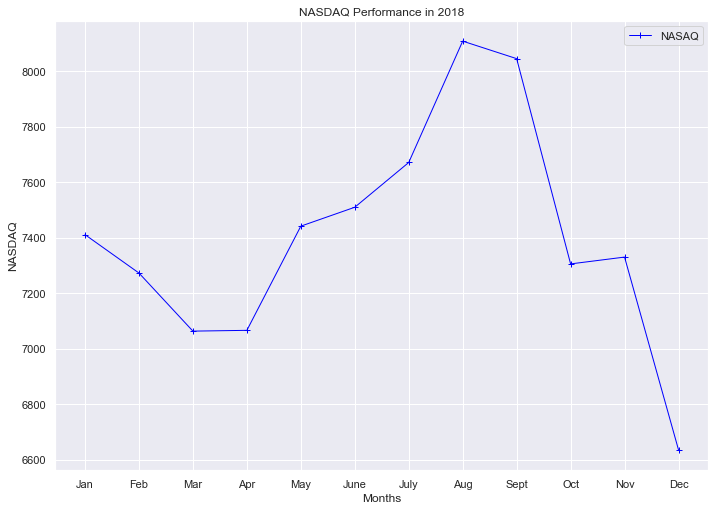

In [49]:
#Created Chart to show NASDAQ Performance
Loans_to_Time = plt.plot(Months, nasdaq_close, marker="+",color="blue", linewidth=1, label="NASAQ")
plt.title("NASDAQ Performance in 2018")
plt.legend(loc="best")
plt.xlabel("Months")
plt.ylabel("NASDAQ")
plt.savefig("images/NASDAQ.png")

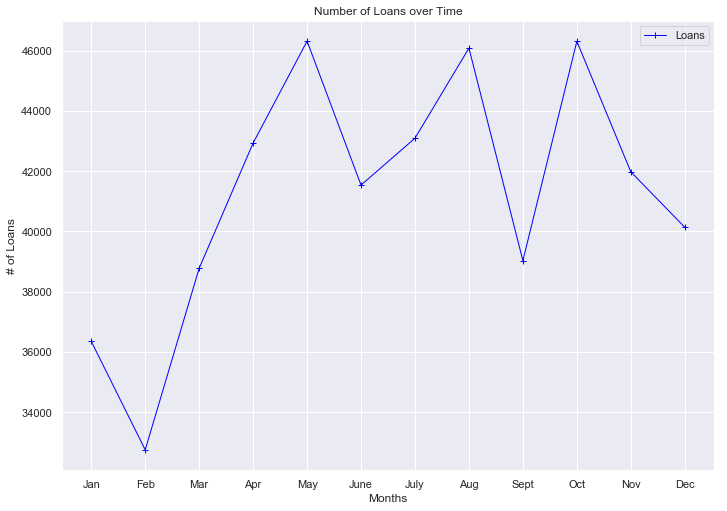

In [50]:
#Created Chart to show number of loans in 2018
Loans_to_Time = plt.plot(Months, Number_of_loans, marker="+",color="blue", linewidth=1, label="Loans")
plt.title("Number of Loans over Time")
plt.legend(loc="best")
plt.xlabel("Months")
plt.ylabel("# of Loans")
plt.savefig("images/Loans to Time.png")

In [51]:
#Created object to store the average interest rate each month
interest_rate_mean = [Jan["int_rate"].mean(),Feb["int_rate"].mean(),Mar["int_rate"].mean(),
                     Apr["int_rate"].mean(),May["int_rate"].mean(),Jun["int_rate"].mean(),
                     Jul["int_rate"].mean(),Aug["int_rate"].mean(),Sept["int_rate"].mean(),
                     Oct["int_rate"].mean(),Nov["int_rate"].mean(),Dec["int_rate"].mean()]
interest_rate_mean

[12.385711337935462,
 12.460560984546227,
 12.431085605220568,
 12.531480851658856,
 12.585767528233356,
 12.561177136255585,
 13.08095267933704,
 12.988853056705207,
 12.78003561727931,
 12.750407731344968,
 13.081794010433915,
 12.980793342302016]

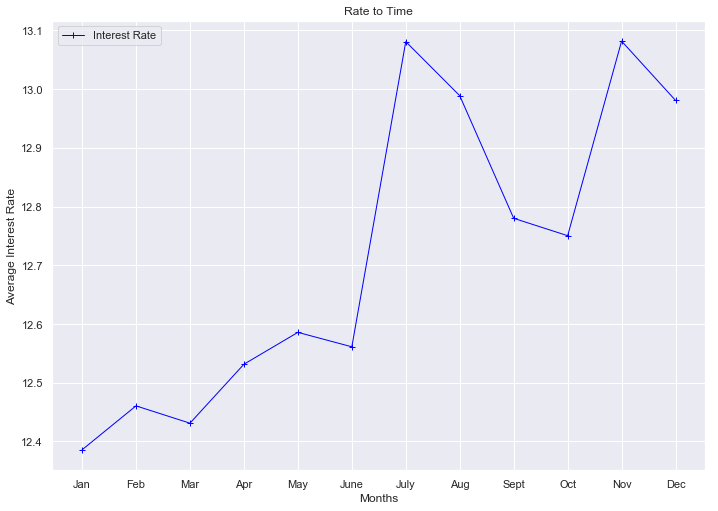

In [52]:
#Chart comparing the average interest rate over 2018
Interest_to_Time = plt.plot(Months, interest_rate_mean, marker="+",color="blue", linewidth=1, label="Interest Rate")
plt.title("Rate to Time")
plt.legend(loc="best")
plt.xlabel("Months")
plt.ylabel("Average Interest Rate")
plt.savefig("images/InterestRatetoTime.png")

In [53]:
#Object containing the sum of the loans given out
total_loans_in_dollars = [Jan["loan_amnt"].sum(),Feb["loan_amnt"].sum(),Mar["loan_amnt"].sum(),
                     Apr["loan_amnt"].sum(),May["loan_amnt"].sum(),Jun["loan_amnt"].sum(),
                     Jul["loan_amnt"].sum(),Aug["loan_amnt"].sum(),Sept["loan_amnt"].sum(),
                     Oct["loan_amnt"].sum(),Nov["loan_amnt"].sum(),Dec["loan_amnt"].sum()]
total_loans_in_dollars

[584275125.0,
 533093100.0,
 624413475.0,
 685339900.0,
 733698150.0,
 661391150.0,
 688012100.0,
 739736100.0,
 635394775.0,
 746131475.0,
 666934725.0,
 637843075.0]

In [54]:
#List containing the Adjusted Close of the DOW
close = otherdf["Adj Close"]
close

0    26,149.39
1     25,029.2
2    24,103.11
3    24,163.15
4    24,415.84
5    24,271.41
6    25,415.19
7    25,964.82
8    26,458.31
9    25,115.76
10   25,538.46
11   23,327.46
Name: Adj Close, dtype: float64

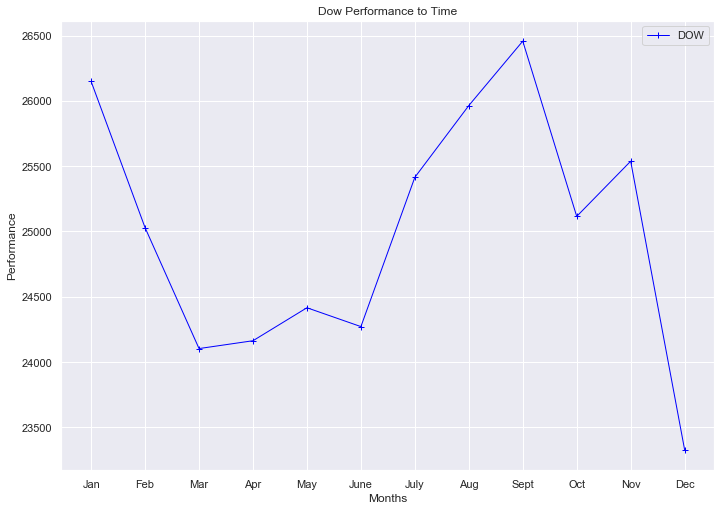

In [55]:
#Create chart showing performance of the DOW
dow = plt.plot(Months, close, marker="+",color="blue", linewidth=1, label="DOW")
plt.title("Dow Performance to Time")
plt.legend(loc="best")
plt.xlabel("Months")
plt.ylabel("Performance")
plt.savefig("images/DOW.png")

In [56]:
#Create a list showing the adjusted close of the VIX
vix= cleanmydf["Adj Close"]
vix

0    13.54
1    19.85
2    19.97
3    15.93
4    15.43
5    16.09
6    12.83
7    12.86
8    12.12
9    21.23
10   18.07
11   25.42
Name: Adj Close, dtype: float64

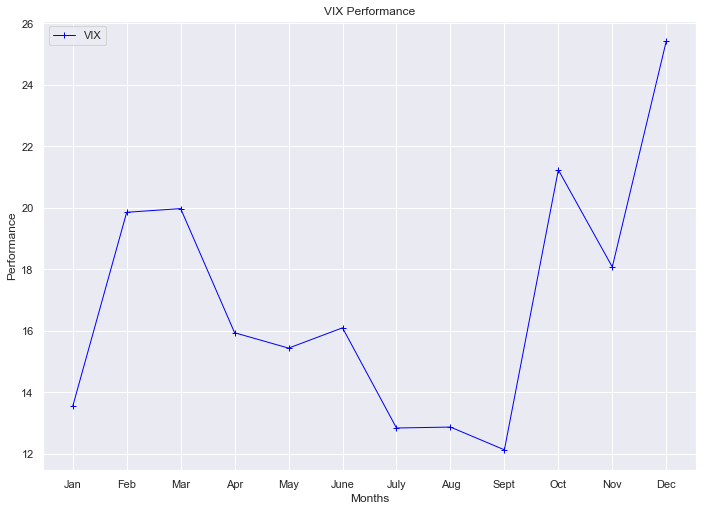

In [57]:
#Create chart showing performance of the VIX
vix_data = plt.plot(Months, vix, marker="+",color="blue", linewidth=1, label="VIX")
plt.title("VIX Performance")
plt.legend(loc="best")
plt.xlabel("Months")
plt.ylabel("Performance")
plt.savefig("images/VIX.png")
plt.show()

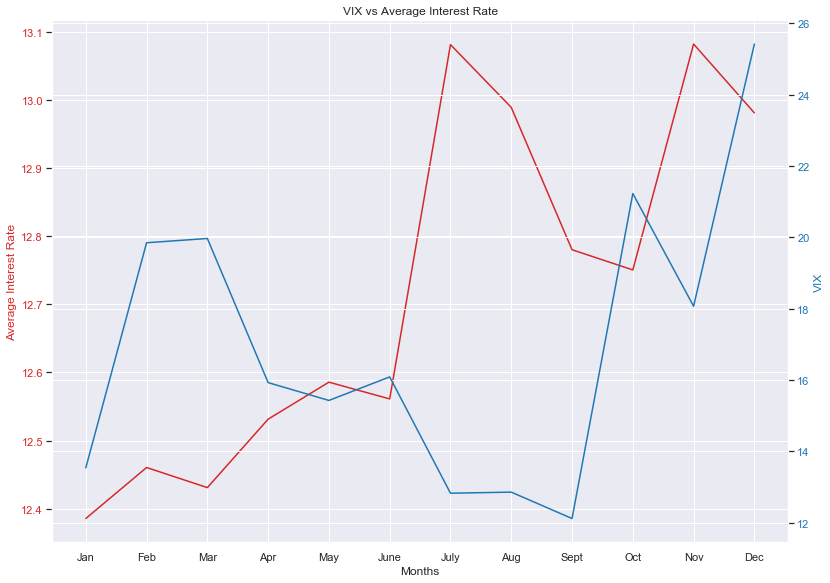

In [58]:
#Comparing VIX vs the Average interest rate
fig, ax1 = plt.subplots()
plt.title("VIX vs Average Interest Rate")
color = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('Average Interest Rate', color=color)
ax1.plot(Months, interest_rate_mean, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('VIX', color=color) 
ax2.plot(Months, vix, color=color)
ax2.tick_params(axis='y', labelcolor=color)


#ax3 = ax1.twinx()
#color = 'tab:green'
#ax3.set_ylabel('DOW', color=color)  
#ax3.plot(Months, close, color=color)
#ax3.tick_params(axis='y', labelcolor=color)
plt.savefig("images/VIXvsInterest.png")

fig.tight_layout()  
plt.show()


In [59]:
spearmanr(vix, interest_rate_mean)

SpearmanrResult(correlation=-0.18181818181818185, pvalue=0.5717012385276553)

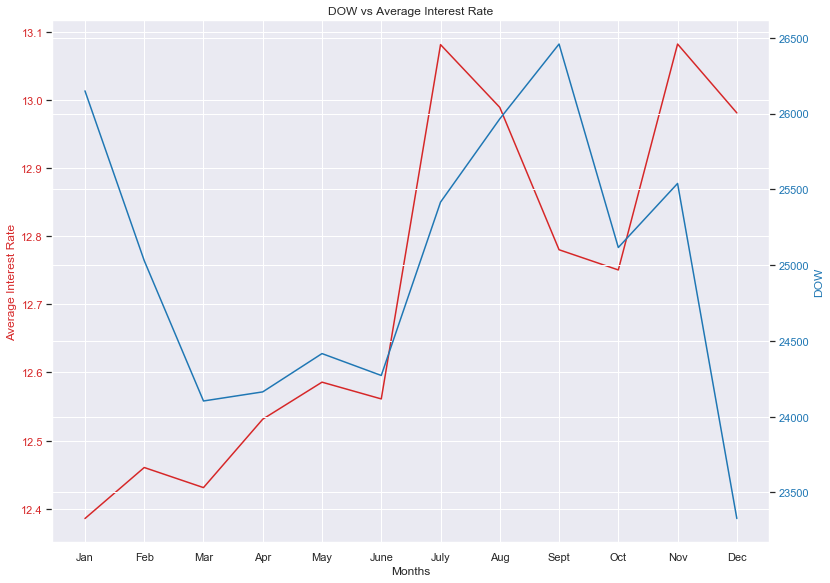

In [60]:
#Chart comparing DOW to average interest rate
fig, ax1 = plt.subplots()
plt.title("DOW vs Average Interest Rate")
color = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('Average Interest Rate', color=color)
ax1.plot(Months, interest_rate_mean, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('DOW', color=color)
ax2.plot(Months, close, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig("images/DOWvsInterest.png")

fig.tight_layout()
plt.show()

In [61]:
spearmanr(interest_rate_mean,close)

SpearmanrResult(correlation=0.2657342657342658, pvalue=0.40383308831471165)

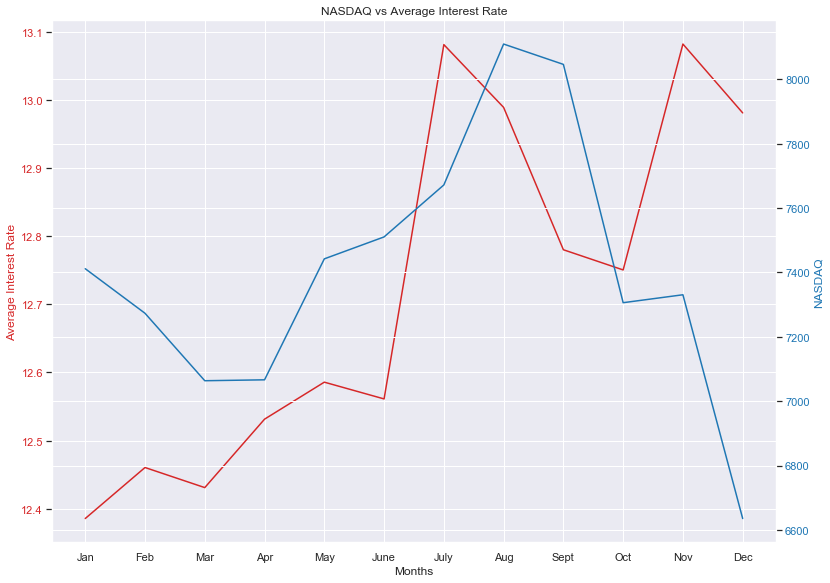

In [62]:
#Chart comparing DOW to average interest rate
fig, ax1 = plt.subplots()
plt.title("NASDAQ vs Average Interest Rate")
color = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('Average Interest Rate', color=color)
ax1.plot(Months, interest_rate_mean, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('NASDAQ', color=color)
ax2.plot(Months, nasdaq_close, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig("images/NasdaqvsInterest.png")

fig.tight_layout()
plt.show()

In [63]:
spearmanr(interest_rate_mean,nasdaq_close)

SpearmanrResult(correlation=0.3846153846153847, pvalue=0.21702022575997748)

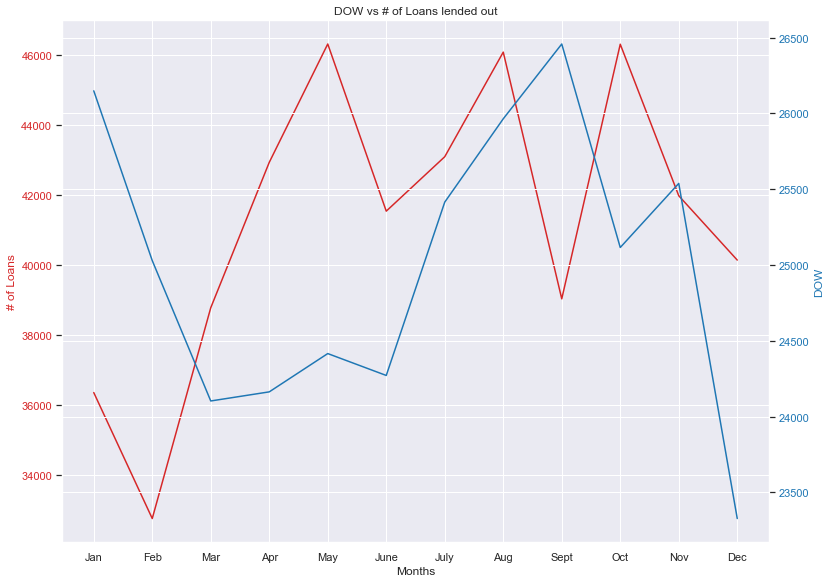

In [64]:
#Chart comparing DOW to # of Loans lended
fig, ax1 = plt.subplots()
plt.title("DOW vs # of Loans lended out")
color = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('# of Loans', color=color)
ax1.plot(Months, Number_of_loans, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('DOW', color=color)
ax2.plot(Months, close, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig("images/Dowvsloans.png")

fig.tight_layout()
plt.show()

In [65]:
spearmanr(Number_of_loans,close)

SpearmanrResult(correlation=0.0, pvalue=1.0)

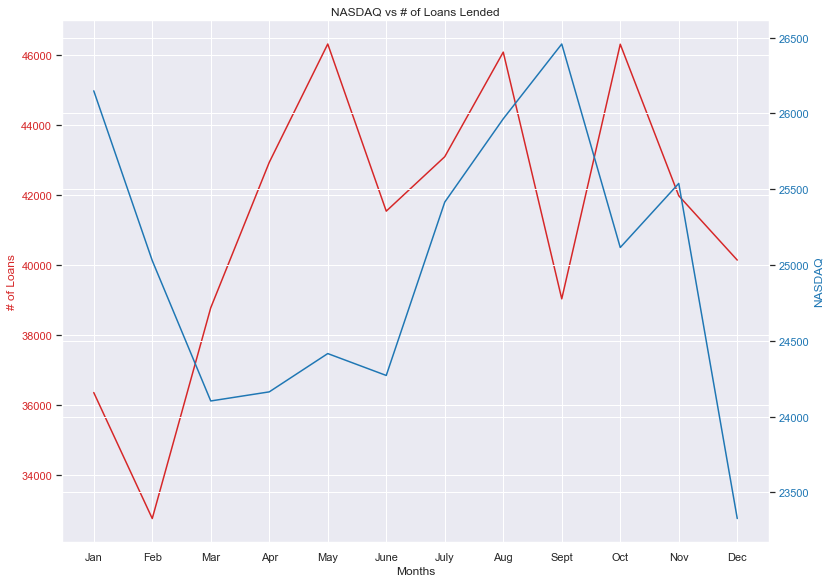

In [66]:
#Chart comparing NASDAQ to # of loans lended
fig, ax1 = plt.subplots()
plt.title("NASDAQ vs # of Loans Lended")
color = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('# of Loans', color=color)
ax1.plot(Months, Number_of_loans, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('NASDAQ', color=color)
ax2.plot(Months, close, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig("images/Nasdaqvsloans.png")

fig.tight_layout()
plt.show()

In [67]:
spearmanr(interest_rate_mean,nasdaq_close)

SpearmanrResult(correlation=0.3846153846153847, pvalue=0.21702022575997748)

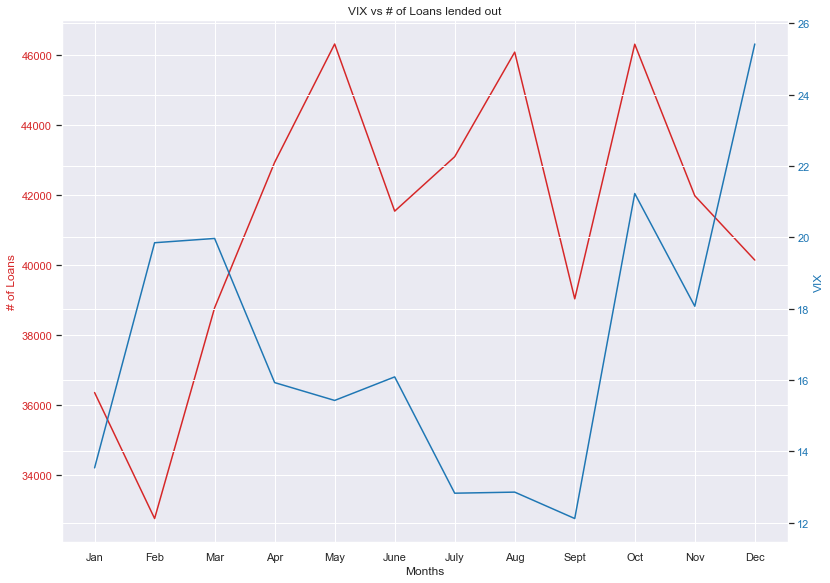

In [68]:
#Chart comparing VIX to # of Loans lended out
fig, ax1 = plt.subplots()
plt.title("VIX vs # of Loans lended out")
color = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('# of Loans', color=color)
ax1.plot(Months, Number_of_loans, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('VIX', color=color)
ax2.plot(Months, vix, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig("images/VIXvsloans.png")

fig.tight_layout()
plt.show()

In [69]:
spearmanr(Number_of_loans,vix)

SpearmanrResult(correlation=-0.14685314685314685, pvalue=0.6487957097846664)

In [70]:
new_merged_df.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,open_acc,month_num,Open,High,Low,Adj Close
0,"30,000.0",36 months,7.34,3 years,OWN,"95,000.0",10.0,3,19.96,26.22,13.31,19.97
1,"34,825.0",60 months,12.61,2 years,MORTGAGE,"125,000.0",12.0,3,19.96,26.22,13.31,19.97
2,"2,600.0",36 months,7.96,3 years,MORTGAGE,"62,000.0",8.0,3,19.96,26.22,13.31,19.97
3,"20,000.0",60 months,9.92,3 years,MORTGAGE,"110,000.0",9.0,3,19.96,26.22,13.31,19.97
4,"17,000.0",60 months,20.39,10+ years,RENT,"52,000.0",9.0,3,19.96,26.22,13.31,19.97


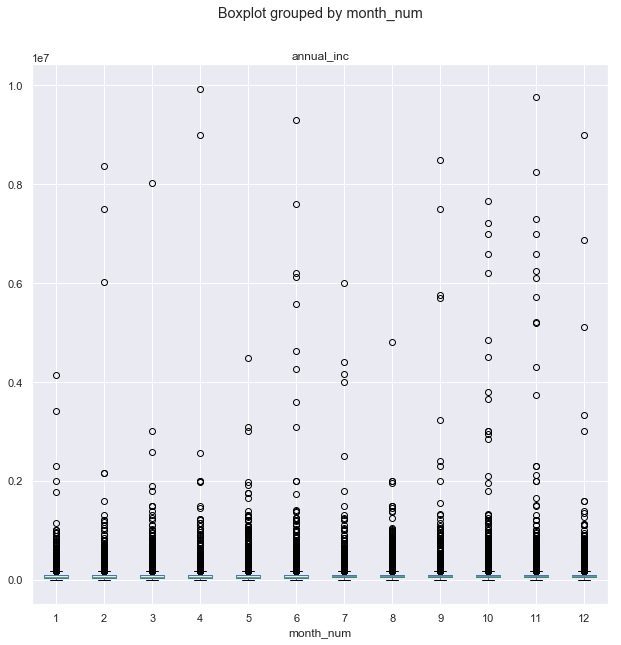

In [71]:
#Boxplot showing the spread of the interest rates by month
new_merged_df.boxplot("annual_inc", by="month_num", figsize=(10, 10))

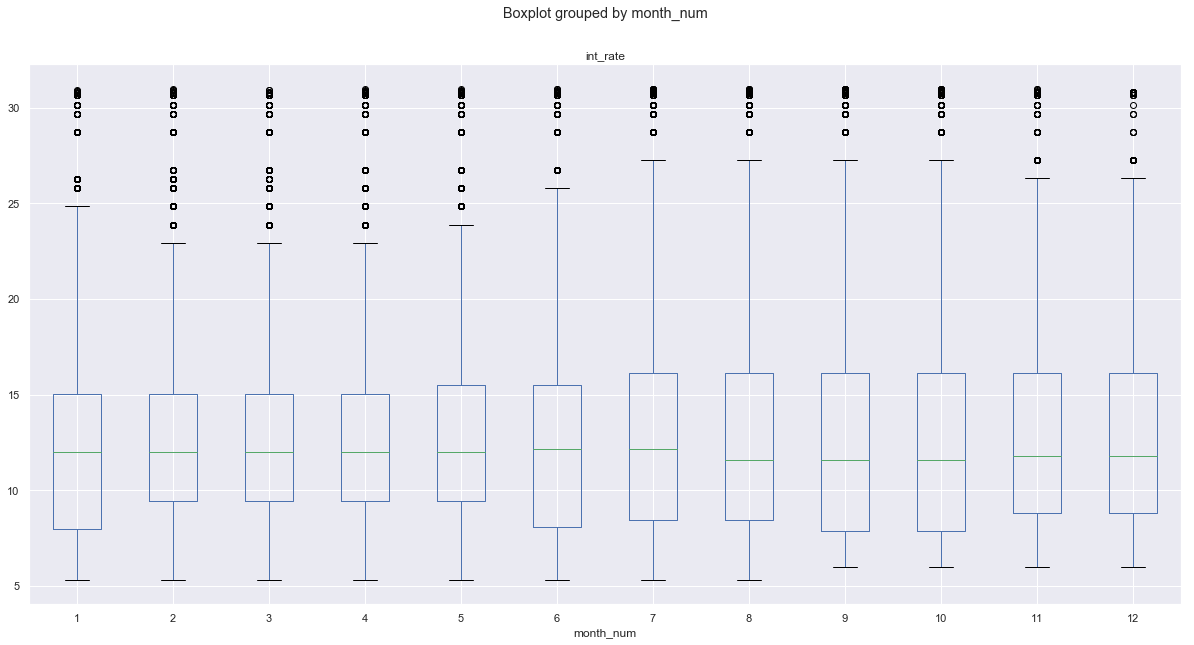

In [72]:
#Boxplot showing the spread of the interest rates by month
new_merged_df.boxplot("int_rate", by="month_num", figsize=(20, 10))

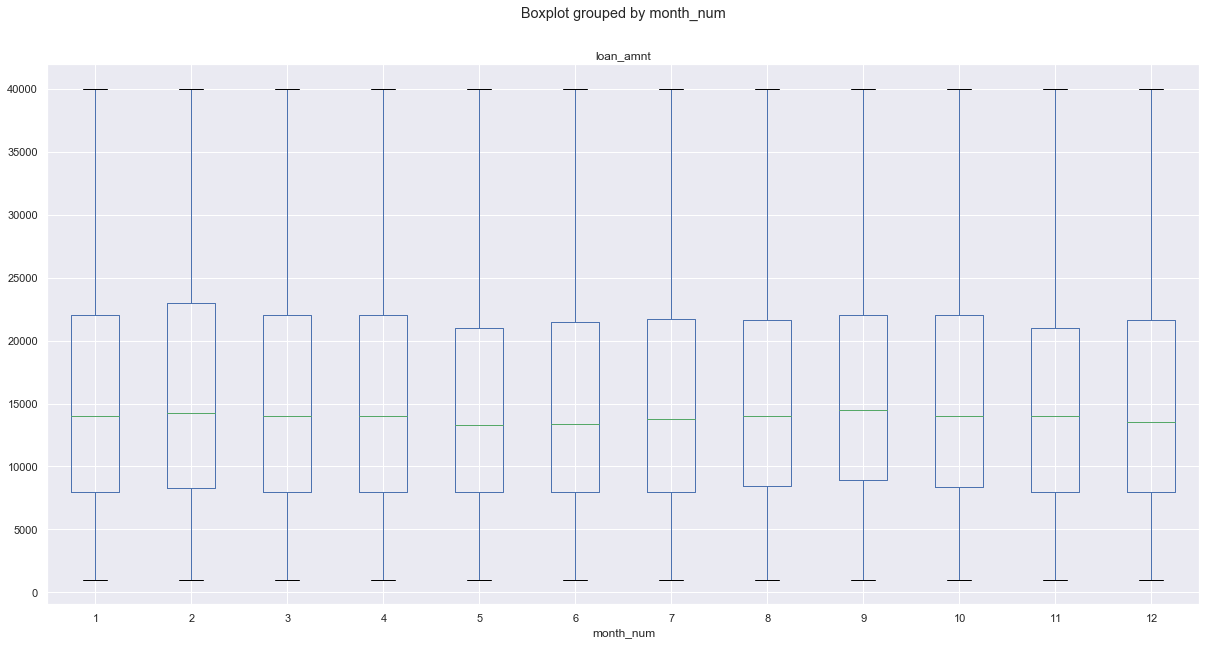

In [73]:
#Boxplot showing the spread of loan amounts given
new_merged_df.boxplot("loan_amnt", by="month_num", figsize=(20, 10))

# Nick's Code

In [74]:
# read in FEMA csv file into dataframe
fema = pd.read_csv('data/DisasterDeclarationsSummaries.csv')

# drop columns that are irrelevant
fema = fema.loc[:, ['disasterNumber', 'state', 'incidentBeginDate',
                'incidentType', 'incidentEndDate']]

# create columns to link with lendingclub.com data
fema['yearBegin'] = fema['incidentBeginDate'].str[:4]
fema['monthBegin'] = fema['incidentBeginDate'].str[5:7]
fema['monthEnd'] = fema['incidentEndDate'].str[5:7]

# drop unix dates from dataframe
fema = fema.loc[:, ['disasterNumber', 'state', 'incidentType', 'yearBegin',
                'monthBegin', 'monthEnd']]

# drop all data outside of 2018
fema = fema[fema['yearBegin'] == '2018']

# drop duplicate rows with same incident named for multiple counties
fema.drop_duplicates(subset=['incidentType','disasterNumber', 'yearBegin','monthBegin','monthEnd'], inplace=True)

# fill in all ending month with beginning month if it is missing
fema.monthEnd.fillna(fema.monthBegin, inplace=True)

# drop irrelevant disasterNumber
fema.drop(columns=['disasterNumber'], inplace=True)

# convert month number strings to numeric
fema['monthBegin'] = fema['monthBegin'].apply(pd.to_numeric, errors='coerce')
fema['monthEnd'] = fema['monthEnd'].apply(pd.to_numeric, errors='coerce')
fema['aftermath'] = fema['monthEnd'] + 1

# clean up the dead rows
fema.dropna(subset=['monthBegin', 'monthEnd'], inplace=True)

bigdf = bigdf.reset_index(drop=True)

In [75]:
# CREATING TRIGGER MARKS IN LENDING CLUB BASED ON FEMA

def checkDisaster(row):
    global fema
    tmp_df = fema[(row['month_num'] >= fema['monthBegin']) 
                  & (row['month_num'] <= fema['monthEnd'])
                  & (fema['state']==row['addr_state'])]
    if len(tmp_df)>0:
        return 'D'
    else:
        return 'N'
    
def checkAftermath(row):
    global fema
    tmp_df = fema[(row['month_num'] == fema['monthEnd']+1)
                  & (fema['state']==row['addr_state'])]
    if len(tmp_df)>0:
        return 'A'
    else:
        return 'N'

def checkDState(row):
    global fema
    tmp_df = fema[(fema['state']==row['addr_state'])]
    if len(tmp_df)>0:
        return 'T'
    else:
        return 'F'

bigdf["Disaster"] = ""
bigdf["DState"] = ""
bigdf["Aftermath"] = ""    
    
bigdf['Disaster'] = bigdf.apply(lambda x: checkDisaster(x), axis=1)
bigdf['DState'] = bigdf.apply(lambda x: checkDState(x), axis=1)
bigdf['Aftermath'] = bigdf.apply(lambda x: checkAftermath(x), axis=1)

In [76]:
bigdf.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,...,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,pct_tl_nvr_dlq,month_num,numericGrade,Disaster,DState,Aftermath
0,"30,000.0",36 months,7.34,930.99,A,3 years,OWN,"95,000.0",Mar-18,Fully Paid,...,19.0,nan,24.0,10.0,90.0,3,1,N,T,N
1,"34,825.0",60 months,12.61,785.45,C,2 years,MORTGAGE,"125,000.0",Mar-18,Current,...,14.0,45.0,15.0,45.0,96.3,3,3,N,T,N
2,"2,600.0",36 months,7.96,81.43,A,3 years,MORTGAGE,"62,000.0",Mar-18,Current,...,45.0,nan,nan,nan,100.0,3,1,N,T,N
3,"20,000.0",60 months,9.92,424.16,B,3 years,MORTGAGE,"110,000.0",Mar-18,Current,...,8.0,nan,4.0,nan,90.9,3,2,N,T,N
4,"17,000.0",60 months,20.39,454.1,D,10+ years,RENT,"52,000.0",Mar-18,Current,...,19.0,77.0,0.0,77.0,85.7,3,4,N,T,N


In [77]:
fema = fema.reset_index(drop=True)
fema.head()

,state,incidentType,yearBegin,monthBegin,monthEnd,aftermath
0,AS,Hurricane,2018,2,2,3
1,AS,Hurricane,2018,2,2,3
2,OK,Fire,2018,3,3,4
3,KY,Flood,2018,2,2,3
4,WV,Mud/Landslide,2018,2,2,3


In [102]:
# make two smaller dataframes: one that is with disasters, one without disasters. 
# Set up 1 Sample Test
disaster_df = bigdf[bigdf['DState'] == 'T']
disaster_samp = disaster_df.loc[:,["loan_amnt", "addr_state", "month_num", "Disaster", "DState", "Aftermath"]]
disaster_samp = disaster_samp.groupby(['month_num']).count()

bigdf_pop = bigdf.loc[:,["loan_amnt", "addr_state", "month_num", "Disaster", "DState", "Aftermath"]]
bigdf_pop = bigdf_pop.groupby(['month_num']).count()

population = list(bigdf_pop.loan_amnt)
sample = list(disaster_samp.loan_amnt)
print(np.corrcoef(population,sample))

[[1.        0.9998459]
 [0.9998459 1.       ]]


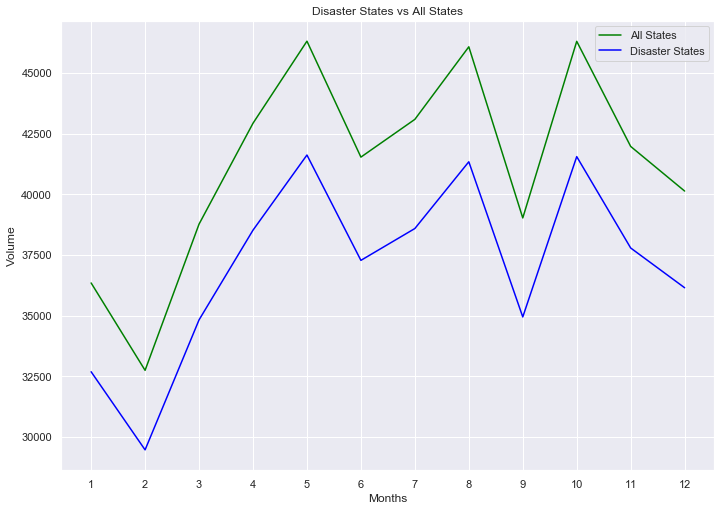

In [79]:
# Create a list of the months that we will use as our x axis
months = [1,2,3,4,5,6,7,8,9,10,11,12]

# Plot our line that will be used to track a wrestler's wins over the years
plt.plot(months, population, color="green", label="All States")

# Plot our line that will be used to track a wrestler's losses over the years
plt.plot(months, sample, color="blue", label="Disaster States")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Disaster States vs All States")
plt.xlabel("Months")
plt.ylabel("Volume")
plt.xticks(months)
plt.savefig("images/DisastervsRegular.png")
# Print our chart to the screen
plt.show()

In [80]:
# pick two states with the most disasters
fema_tot_count = fema.groupby(["state"]).count()
fema_tot_count

,incidentType,yearBegin,monthBegin,monthEnd,aftermath
state,,,,,
AK,3,3,3,3,3
AL,3,3,3,3,3
AS,2,2,2,2,2
AZ,4,4,4,4,4
CA,16,16,16,16,16
CO,3,3,3,3,3
CT,2,2,2,2,2
FL,3,3,3,3,3
GA,2,2,2,2,2


In [81]:
fema_type_count = fema.groupby(["incidentType"])['state'].count()
fema_type_count

incidentType
Coastal Storm       3
Earthquake          2
Fire               56
Flood              19
Hurricane          20
Mud/Landslide       1
Severe Storm(s)    19
Snow                3
Tornado             1
Typhoon             2
Volcano             1
Name: state, dtype: int64

In [82]:
state1_df = disaster_df[disaster_df["addr_state"] == 'VA']
state2_df = disaster_df[disaster_df["addr_state"] == 'WV']

In [83]:
state1_d_df = state1_df[state1_df["Disaster"] == 'D']
state1_d_count = state1_d_df.groupby(["month_num"])["loan_amnt"].count()
state1_d_count

month_num
9      987
10    1169
Name: loan_amnt, dtype: int64

In [84]:
state2_d_df = state2_df[state2_df["Disaster"] == 'D']
state2_d_count = state2_d_df.groupby(["month_num"])["loan_amnt"].count()
state2_d_count

month_num
2    215
5    317
6    228
Name: loan_amnt, dtype: int64

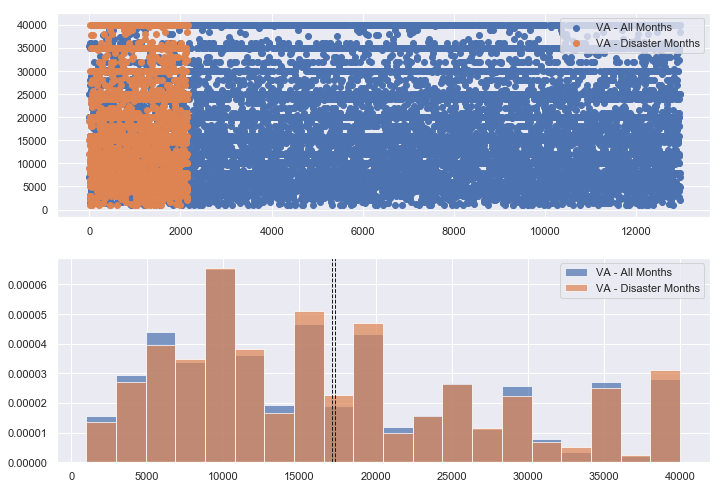

In [85]:
vapopulation = np.array(list(state1_df.loan_amnt))
vasample = np.array(list(state1_d_df.loan_amnt))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(vapopulation)), vapopulation, label="VA - All Months")
plt.scatter(range(len(vasample)), vasample, label="VA - Disaster Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(vapopulation, 20, density=True, alpha=0.7, label="VA - All Months")
plt.hist(vasample, 20, density=True, alpha=0.7, label="VA - Disaster Months")
plt.axvline(vapopulation.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(vasample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()
plt.savefig("images/vastatcompare.png")

In [86]:
import scipy.stats as stats

stats.ttest_1samp(vasample, vapopulation.mean())

Ttest_1sampResult(statistic=0.9092917389993791, pvalue=0.3632978317944181)

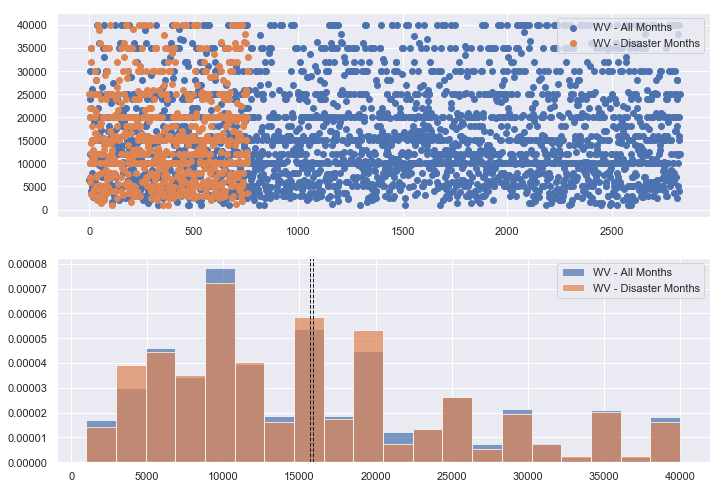

In [87]:
wvpopulation = np.array(list(state2_df.loan_amnt))
wvsample = np.array(list(state2_d_df.loan_amnt))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(wvpopulation)), wvpopulation, label="WV - All Months")
plt.scatter(range(len(wvsample)), wvsample, label="WV - Disaster Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(wvpopulation, 20, density=True, alpha=0.7, label="WV - All Months")
plt.hist(wvsample, 20, density=True, alpha=0.7, label="WV - Disaster Months")
plt.axvline(wvpopulation.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(wvsample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [88]:
stats.ttest_1samp(wvsample, wvpopulation.mean())

Ttest_1sampResult(statistic=-0.5362342559632381, pvalue=0.5919537786233782)

In [89]:
# Checking aftermath loan sizes
state1_a_df = state1_df[state1_df["Aftermath"] == 'A']
state1_a_count = state1_a_df.groupby(["month_num"])["loan_amnt"].count()
state1_a_count

month_num
10    1169
11    1164
Name: loan_amnt, dtype: int64

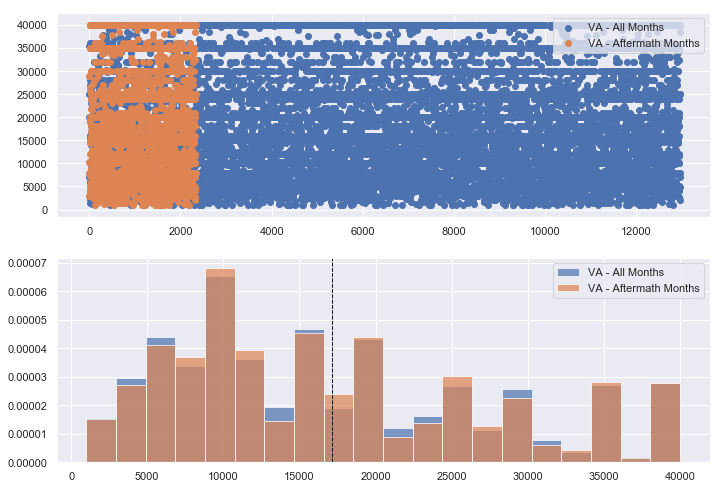

In [90]:
va_a_population = np.array(list(state1_df.loan_amnt))
va_a_sample = np.array(list(state1_a_df.loan_amnt))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(va_a_population)), va_a_population, label="VA - All Months")
plt.scatter(range(len(va_a_sample)), va_a_sample, label="VA - Aftermath Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(va_a_population, 20, density=True, alpha=0.7, label="VA - All Months")
plt.hist(va_a_sample, 20, density=True, alpha=0.7, label="VA - Aftermath Months")
plt.axvline(va_a_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(va_a_sample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [91]:
stats.ttest_1samp(va_a_sample, va_a_population.mean())

Ttest_1sampResult(statistic=-0.05838991874207314, pvalue=0.9534430474445266)

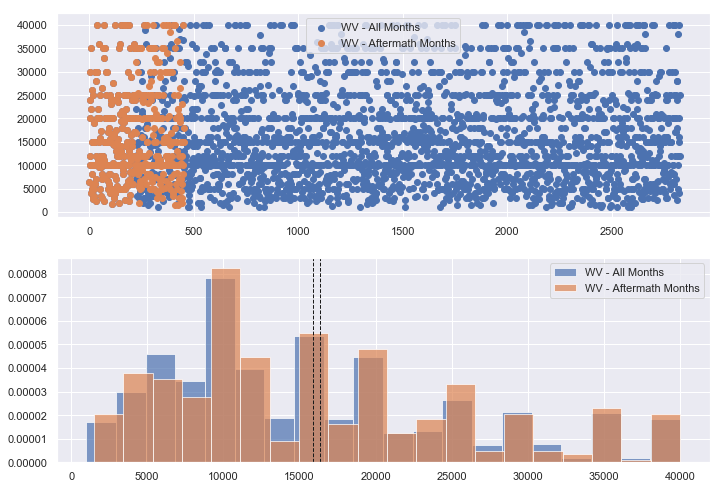

In [92]:
# Checking aftermath loan sizes
state2_a_df = state2_df[state2_df["Aftermath"] == 'A']
state2_a_count = state2_a_df.groupby(["month_num"])["loan_amnt"].count()

wv_a_population = np.array(list(state2_df.loan_amnt))
wv_a_sample = np.array(list(state2_a_df.loan_amnt))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(wv_a_population)), wv_a_population, label="WV - All Months")
plt.scatter(range(len(wv_a_sample)), wv_a_sample, label="WV - Aftermath Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(wv_a_population, 20, density=True, alpha=0.7, label="WV - All Months")
plt.hist(wv_a_sample, 20, density=True, alpha=0.7, label="WV - Aftermath Months")
plt.axvline(wv_a_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(wv_a_sample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [93]:
stats.ttest_1samp(wv_a_sample, wv_a_population.mean())

Ttest_1sampResult(statistic=1.0095511140712456, pvalue=0.31325052190534075)

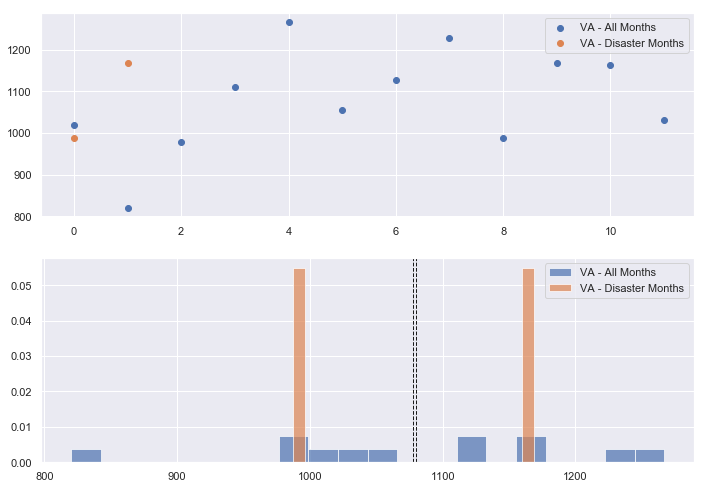

In [94]:
# Checking volumes during disaster months
state1_d_count
state1_v_count = state1_df.groupby(["month_num"])["loan_amnt"].count()

va_v_population = np.array(list(state1_v_count))
va_v_sample = np.array(list(state1_d_count))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(va_v_population)), va_v_population, label="VA - All Months")
plt.scatter(range(len(va_v_sample)), va_v_sample, label="VA - Disaster Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(va_v_population, 20, density=True, alpha=0.7, label="VA - All Months")
plt.hist(va_v_sample, 20, density=True, alpha=0.7, label="VA - Disaster Months")
plt.axvline(va_v_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(va_v_sample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [95]:
stats.ttest_1samp(va_v_sample, va_v_population.mean())

Ttest_1sampResult(statistic=-0.02197802197802198, pvalue=0.9860106088091637)

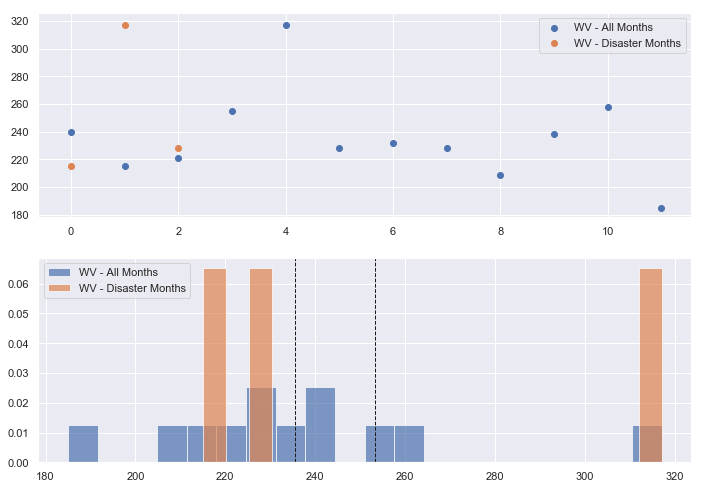

In [96]:
state2_d_count
state2_v_count = state2_df.groupby(["month_num"])["loan_amnt"].count()

wv_v_population = np.array(list(state2_v_count))
wv_v_sample = np.array(list(state2_d_count))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(wv_v_population)), wv_v_population, label="WV - All Months")
plt.scatter(range(len(wv_v_sample)), wv_v_sample, label="WV - Disaster Months")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(wv_v_population, 20, density=True, alpha=0.7, label="WV - All Months")
plt.hist(wv_v_sample, 20, density=True, alpha=0.7, label="WV - Disaster Months")
plt.axvline(wv_v_population.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(wv_v_sample.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

In [97]:
stats.ttest_1samp(wv_v_sample, wv_v_population.mean())

Ttest_1sampResult(statistic=0.5563567393818534, pvalue=0.6339071188089489)

In [98]:
wv_v_population

array([240, 215, 221, 255, 317, 228, 232, 228, 209, 238, 258, 185])

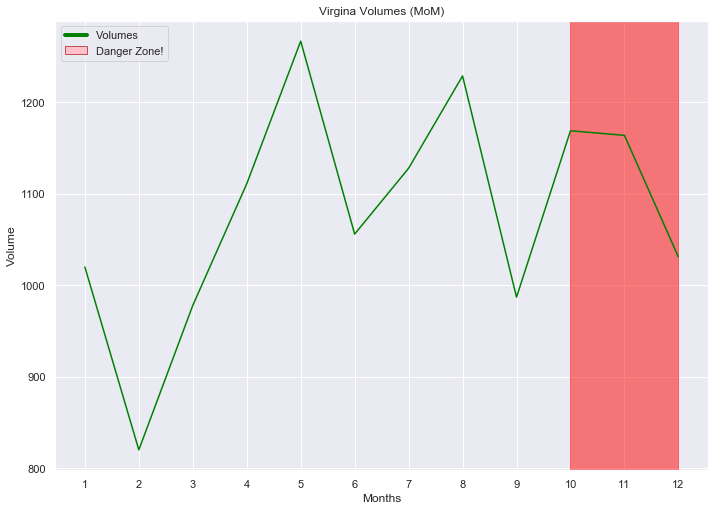

In [99]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Plot our line that will be used to track a wrestler's wins over the years
plt.plot(months, va_v_population, color="green", label="Virginia")
legend_elements = [Line2D([0], [0], color='green', lw=4, label='Volumes'),
                   Patch(facecolor='pink', edgecolor='r',
                         label='Danger Zone!')]
plt.legend(loc="best",handles=legend_elements)
plt.title("Virgina Volumes (MoM)")
plt.xlabel("Months")
plt.ylabel("Volume")
plt.axvspan(10, 12, color='red', alpha=0.5, label="Danger Zone!")
plt.xticks(months)
# Print our chart to the screen
plt.savefig("images/vadisasterline.png")
plt.show()

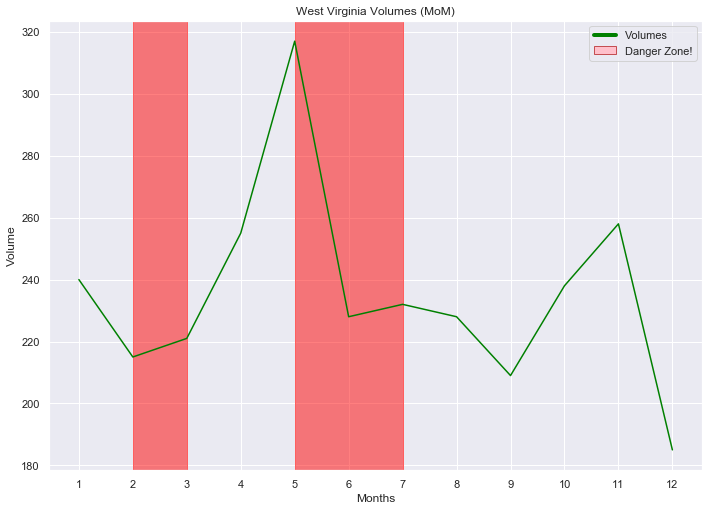

In [100]:
# Plot our line that will be used to track a wrestler's wins over the years
plt.plot(months, wv_v_population, color="green", label="West Virginia")
legend_elements = [Line2D([0], [0], color='green', lw=4, label='Volumes'),
                   Patch(facecolor='pink', edgecolor='r',
                         label='Danger Zone!')]
plt.legend(loc="best",handles=legend_elements)
plt.title("West Virginia Volumes (MoM)")
plt.xlabel("Months")
plt.ylabel("Volume")
plt.axvspan(2, 3, color='red', alpha=0.5, label="Danger Zone!")
plt.axvspan(5, 7, color='red', alpha=0.5, label="Danger Zone!")
plt.xticks(months)
# Print our chart to the screen
plt.show()